In [1]:
%load_ext cudf.pandas
import pandas as pd

In [2]:
import sys
sys.path.append("..")
import cupyx.scipy.stats as cstats
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
import warnings
warnings.filterwarnings('ignore')
from src.data_processing import *
sns.set(rc={'figure.figsize':(8,6)})
%matplotlib inline
# pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 1. Import data and inspection

In [3]:
DATA_PATH = '../data/immo_data.csv'
apartment_df = pd.read_csv(DATA_PATH, header=0)

## 1.1. An overview on the dataset

The explanation of the each column can be found here: https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany/data

Total rent (usually a sum of base rent, service charge and heating cost). So, `serviceCharge` will **overlap** with the *Internet and TV services*

In [4]:
apartment_df.describe(datetime_is_numeric=True)

,serviceCharge,telekomHybridUploadSpeed,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,yearConstructedRange,baseRent,livingSpace,baseRentRange,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice
count,261941.000000,45020.0,268850.000000,267018.000000,235492.000000,2.283330e+05,211805.000000,2.688500e+05,93052.000000,211805.000000,2.688500e+05,268850.000000,268850.000000,268850.000000,268850.000000,162344.000000,217541.000000,171118.000000,268850.000000,268850.000000,85518.000000,80711.000000,46846.000000,46846.000000
mean,151.206113,10.0,9.791958,3.389001,28.804928,9.013315e+02,1966.400590,1.069697e+08,1.327634,3.714544,6.941294e+02,74.355548,3.765256,37283.022235,2.641261,114.749533,2.122405,3.572319,2.571542,3.070790,76.990866,2013.904536,89.113612,0.199769
std,308.295790,0.0,6.408399,1.964874,16.337151,3.323833e+04,46.992207,1.250093e+07,8.361403,2.738134,1.953602e+04,254.759208,2.214357,27798.037296,2.633440,61.653663,3.634934,6.375496,0.937594,1.407127,147.716278,10.963125,5.395805,0.009667
min,0.000000,10.0,0.000000,-12.330000,1.000000,0.000000e+00,1000.000000,2.887174e+07,0.000000,1.000000,0.000000e+00,0.000000,1.000000,852.000000,1.000000,0.100000,-1.000000,0.000000,1.000000,1.000000,0.000000,1015.000000,71.430000,0.170500
25%,95.000000,10.0,6.000000,2.000000,10.000000,4.698000e+02,1950.000000,1.066910e+08,1.000000,1.000000,3.380000e+02,54.000000,2.000000,9128.000000,2.000000,79.000000,1.000000,2.000000,2.000000,2.000000,54.000000,2012.000000,90.760000,0.191500
50%,135.000000,10.0,9.000000,3.390000,40.000000,6.500000e+02,1973.000000,1.111584e+08,1.000000,3.000000,4.900000e+02,67.320000,3.000000,38667.000000,3.000000,107.000000,2.000000,3.000000,3.000000,3.000000,70.000000,2017.000000,90.760000,0.198500
75%,190.000000,10.0,13.000000,4.570000,40.000000,9.850000e+02,1996.000000,1.137688e+08,1.000000,5.000000,7.990000e+02,87.000000,5.000000,57072.000000,3.000000,140.300000,3.000000,4.000000,3.000000,4.000000,90.000000,2019.000000,90.760000,0.205500
max,146118.000000,10.0,121.000000,14.920000,100.000000,1.575154e+07,2090.000000,1.157117e+08,2241.000000,9.000000,9.999999e+06,111111.000000,9.000000,99998.000000,999.990000,1996.000000,999.000000,999.000000,5.000000,7.000000,12613.000000,2919.000000,90.760000,0.227600


In [5]:
print(f"The number of feature are: {apartment_df.shape[1]} \n\
The number of example are: {apartment_df.shape[0]}")

The number of feature are: 49 
The number of example are: 268850


In [6]:
md(f"The list of features:\n\n {apartment_df.columns.to_list()}")

The list of features:

 ['regio1', 'serviceCharge', 'heatingType', 'telekomTvOffer', 'telekomHybridUploadSpeed', 'newlyConst', 'balcony', 'picturecount', 'pricetrend', 'telekomUploadSpeed', 'totalRent', 'yearConstructed', 'scoutId', 'noParkSpaces', 'firingTypes', 'hasKitchen', 'geo_bln', 'cellar', 'yearConstructedRange', 'baseRent', 'houseNumber', 'livingSpace', 'geo_krs', 'condition', 'interiorQual', 'petsAllowed', 'street', 'streetPlain', 'lift', 'baseRentRange', 'typeOfFlat', 'geo_plz', 'noRooms', 'thermalChar', 'floor', 'numberOfFloors', 'noRoomsRange', 'garden', 'livingSpaceRange', 'regio2', 'regio3', 'description', 'facilities', 'heatingCosts', 'energyEfficiencyClass', 'lastRefurbish', 'electricityBasePrice', 'electricityKwhPrice', 'date']

* Since the data is scraped from immobilienscout24.de, each listing is identified by an unique ID number, presented in `scoutId` column. Hence, to check duplications of the data, all the duplications in `scoutId` is dropped.

In [7]:
# Use listing ID (`scoutId`) to check for dupplicated values
apartment_df = apartment_df.drop_duplicates(subset='scoutId')

After reviewing the explaination of each columns, the repeated information should be dropped.
The table below shows the dropped columns that have dupplicated infomation:

|Table name | Description | Note |
| --------- | ----------- | ---- |
|regio1 | replace with coordinate in feature engineering section | |
|regio2 | replace with coordinate in feature engineering section | |
|regio3 | replace with coordinate in feature engineering section | |
|geo_bln | bundesland (state), same as regio1 | duplicated|
|geo_krs | District or Kreis, same as regio2 | duplicated|
|street | too specific and may not generalize well | duplicated |
|streetPlain | too specific and may not generalize well| duplicated |
|houseNumber | too specific and may not generalize well| duplicated |
| thermalChar | it is deprecated | |
| telekomUploadSpeed| too specific and may not generalize well| |
| telekomHybridUploadSpeed| too specific and may not generalize well| |
| energyEfficiencyClass| `serviceCharge` cover this info| duplicated|
| electricityBasePrice| `serviceCharge` cover this info | duplicated|
| electricityKwhPrice| `serviceCharge` cover this info |duplicated|
| livingSpaceRange| a diff. format of `livingSpace`|duplicated|
| noRoomsRange|a diff. format of `noRooms`|duplicated|
| baseRentRange |a diff. format of`baseRent` |duplicated|
| yearConstructedRange |a diff. format of `yearConstructed` |duplicated|

In [8]:
# delete_cols = ['regio1', 'regio2', 'regio3','geo_bln', 'geo_krs', 'street', 'streetPlain', 'houseNumber',
#                'thermalChar','telekomUploadSpeed', 'telekomHybridUploadSpeed',
#                'energyEfficiencyClass','electricityBasePrice','electricityKwhPrice',
#                'livingSpaceRange', 'noRoomsRange','baseRentRange','yearConstructedRange']

# apartment_df = apartment_df.drop(delete_cols, axis=1)

* For the first part of the solution, two textual data columns are not considered, hence, they're dropped

In [9]:
# apartment_df = apartment_df.drop(['description', 'facilities'], axis=1)

## 1.2. Features engineering

### 1.2.1 Convert all location data to the distance from them to **Stuttgart** (48.7758° N, 9.1829° E)

The location is importance features for predicting rental prices. These features can provide valuable spatial information that may contribute to the model's predictive power. This dataset has 6 columns related to location, which can greately reduce to one column `distance`.\
The distance to a specific location is measurable, numeric, and distinct, will works nicely for regression model. Stuttgart is chosen for reference point.

The data for coordinates is from: https://gist.github.com/iteufel/af379872bbc3bf5261e2fd09b681ff7e.\
Then, it is converted to csv using function `sql2csv` in `src/data_processing.py`

In [10]:
zip_coordinates = pd.read_csv('../data/zip_coordinates.csv', header=0)

Matching the zipcodes with col. `geo_plz`, then add the corresponding latitude and longitude coordinate.

In [11]:
merged_dataset = pd.merge_asof(apartment_df.sort_values('geo_plz'),
                               zip_coordinates[['zipcode', 'lat', 'lon']].sort_values('zipcode'),
                               left_on='geo_plz', right_on='zipcode',
                               direction='nearest')

In [12]:
# Verifying the results
verification_result = merged_dataset['geo_plz'] == merged_dataset['zipcode']

# Count the number of discrepancies
num_discrepancies = verification_result.value_counts()
percent = 100 * (num_discrepancies[False] / merged_dataset.shape[0])
# Display the verification result
print("Verification Result:")
print(f"Matched: {num_discrepancies[True]}")
print(f"Mismatched: {num_discrepancies[False]} ({percent:2f} %)")

Verification Result:
Matched: 267525
Mismatched: 1325 (0.492840 %)


* The mismatched is only 0.4 %, so far so good. Compute the distance from Stuttgart (48.7758° N, 9.1829° E) for all the rows.

In [14]:
# Reference coordinates for Stuttgart
ref_lat = 48.7758
ref_lon = 9.1829
# Create a new column 'distance' using the haversine_distance_cudf function
merged_dataset['distance'] = haversine_distance(merged_dataset['lat'],
                                                merged_dataset['lon'],
                                                ref_lat, ref_lon)

<Axes: ylabel='Frequency'>

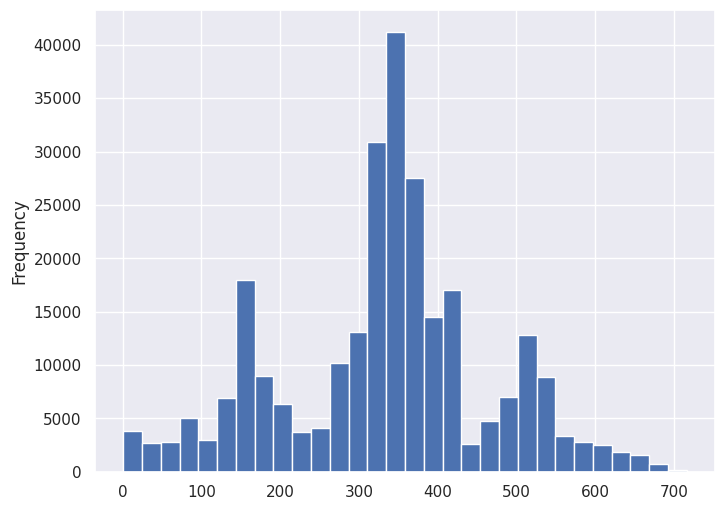

In [19]:
merged_dataset['distance'].plot.hist(bins=30)

### 1.2.3 Age of the building

`yearConstructed` is good features for price predictions, this col. can be improve by:
1. Correct the values in `newlyConst`, then
2. The missing values of `yearConstructed` can be filled appocimately by the info in `newlyConst`, by fill all missing rows with year: **2017** if their values in `newlyConst` = True


In [19]:
# Calculate missing values
missing_count = apartment_df['yearConstructed'].isnull().sum()
percentage_missing = (missing_count / apartment_df['yearConstructed'].shape[0]) * 100
print(f"The percentage of missing values `yearConstructed`: {percentage_missing:2f} %")

The percentage of missing values `yearConstructed`: 21.218151 %


In [20]:
# Calculate missing values
missing_count = apartment_df['newlyConst'].isnull().sum()
percentage_missing = (missing_count / apartment_df['newlyConst'].shape[0]) * 100
print(f"The percentage of missing values `newlyConst`: {percentage_missing:2f} %")

The percentage of missing values `newlyConst`: 0.000000 %


Drop unrealistic values

In [21]:
# apartment_df = apartment_df.drop(apartment_df[apartment_df['yearConstructed'] > 2022].index)

The codes below shows the year assigned for `True` and `False` in col. `newlyConst`. There are values that not appropreated, e.g value for `True` starting from **2017**, however, thousound of values of 2017, 2018 are assigned for `False`. So they are needed to convert back to `True`.

In [22]:
new_apart_df = apartment_df[apartment_df['newlyConst'] == True]
old_apart_df = apartment_df[apartment_df['newlyConst'] == False]

In [23]:
new_apart_df['yearConstructed'].value_counts().sort_index()

2017      928
2018     7122
2019    10959
2020     2140
2021       15
2022        2
2026        3
2029        1
2090        1
Name: yearConstructed, dtype: int64

In [24]:
old_apart_df['yearConstructed'].value_counts().sort_index(ascending=False).head(10)

2018    1637
2017    2975
2016    2902
2015    2288
2014    1873
2013    1408
2012    1217
2011     792
2010     821
2009     617
Name: yearConstructed, dtype: int64

In [25]:
# Convert to True for house built from 2017
df = apartment_df
# df.loc[apartment_df['yearConstructed'].notna(), 'newlyConst'] = >= 2017

In [26]:
 df['yearConstructed'].notna()

0         True
1         True
2         True
3         True
4         True
          ... 
268845    True
268846    True
268847    True
268848    True
268849    True
Name: yearConstructed, Length: 268850, dtype: bool

In [27]:
old_apart_df = df[apartment_df['newlyConst'] == False]

In [28]:
old_apart_df['yearConstructed'].value_counts().sort_index(ascending=False).head(10)

2018    1637
2017    2975
2016    2902
2015    2288
2014    1873
2013    1408
2012    1217
2011     792
2010     821
2009     617
Name: yearConstructed, dtype: int64

In [29]:
apartment_df.loc[apartment_df['yearConstructed'].isna(), 'newlyConst'].sum()

0

In [30]:


# Step 1: Correct values in newlyConst
df['newlyConst'] = df['newlyConst'].replace({True: 1, False: 0})

# Step 2: Fill missing values in yearConstructed based on newlyConst
df['yearConstructed'] = df['yearConstructed'].combine_first(df['newlyConst'].replace({1: 2017}))


In [31]:
df['yearConstructed'].isna().sum()

0

In [32]:
# Calculate missing values
df['yearConstructed'].isnull().sum()
# percentage_missing = (missing_count / df['yearConstructed'].shape[0]) * 100
# print(f"The percentage of missing values `yearConstructed`: {percentage_missing:2f} %")

0

In [33]:
# Calculate missing values
missing_count = df['newlyConst'].isnull().sum()
percentage_missing = (missing_count / df['newlyConst'].shape[0]) * 100
print(f"The percentage of missing values `newlyConst`: {percentage_missing:2f} %")

The percentage of missing values `newlyConst`: 0.000000 %


In [34]:
df['yearConstructed'] = df['yearConstructed'].fillna(df['newlyConst'].apply(lambda x: 2017 if x else None))

In [35]:
# Create new `Years` col by get the last 2 values of col `date`
apartment_df = apartment_df.assign(Years=apartment_df.date.str[-2:])
apartment_df['Years'] =  2000 + pd.to_numeric(apartment_df['Years'], errors='coerce')

# Creat new `Age` col for the dataset
df = apartment_df
df['buildingAge'] = apartment_df['Years'] - apartment_df['yearConstructed']
df['buildingAge'].value_counts().sort_index()

-71.0          1
-9.0           1
-7.0           3
-2.0           4
-1.0         519
 0.0       11589
 1.0        9054
 2.0        4222
 3.0        2941
 4.0        2322
 5.0        1961
 6.0        1480
 7.0        1188
 8.0         940
 9.0         761
 10.0        686
 11.0        698
 12.0        660
 13.0        661
 14.0        645
 15.0        652
 16.0        690
 17.0        781
 18.0        923
 19.0       1347
 20.0       1749
 21.0       2287
 22.0       3298
 23.0       4007
 24.0       4237
 25.0       3447
 26.0       2398
 27.0       1824
 28.0       1595
 29.0       1580
 30.0       1679
 31.0       1415
 32.0       1313
 33.0       1599
 34.0       2029
 35.0       2109
 36.0       2102
 37.0       2110
 38.0       2013
 39.0       2258
 40.0       1997
 41.0       2083
 42.0       1891
 43.0       1961
 44.0       2352
 45.0       2655
 46.0       2967
 47.0       3229
 48.0       2972
 49.0       2917
 50.0       2798
 51.0       2496
 52.0       2369
 53.0       22

## 1.3. Data cleaning

Checking the missing values of each feature. List the number of missing values in each columns.

In [36]:
report = missing_values(apartment_df)
report

,Missing count,Percentage
telekomHybridUploadSpeed,223830,83.254603
electricityBasePrice,222004,82.575414
electricityKwhPrice,222004,82.575414
energyEfficiencyClass,191063,71.066766
lastRefurbish,188139,69.979171
heatingCosts,183332,68.191185
noParkSpaces,175798,65.388879
petsAllowed,114573,42.615957
interiorQual,112665,41.906267
thermalChar,106506,39.615399


* It's evident that there plenty of columns that have high amount of missing data, and filling missing values techniues will be not effective with too high level of missing. Hence, dropping all columns with missing percentage > **35%**

In [37]:
# Drop columns with missing values above threshold
threshold = 35
cols_to_drop = report[report['Percentage'] > threshold].index.to_list()
print(f'The {len(cols_to_drop)} dropped columns are:\n', cols_to_drop)
apartment_df = apartment_df.drop(cols_to_drop, axis=1)

The 11 dropped columns are:
 ['telekomHybridUploadSpeed', 'electricityBasePrice', 'electricityKwhPrice', 'energyEfficiencyClass', 'lastRefurbish', 'heatingCosts', 'noParkSpaces', 'petsAllowed', 'interiorQual', 'thermalChar', 'numberOfFloors']


In [38]:
print(f'The {len(apartment_df.columns)} remaining columns are:')
md(f"{apartment_df.columns.to_list()}")

The 40 remaining columns are:


['regio1', 'serviceCharge', 'heatingType', 'telekomTvOffer', 'newlyConst', 'balcony', 'picturecount', 'pricetrend', 'telekomUploadSpeed', 'totalRent', 'yearConstructed', 'scoutId', 'firingTypes', 'hasKitchen', 'geo_bln', 'cellar', 'yearConstructedRange', 'baseRent', 'houseNumber', 'livingSpace', 'geo_krs', 'condition', 'street', 'streetPlain', 'lift', 'baseRentRange', 'typeOfFlat', 'geo_plz', 'noRooms', 'floor', 'noRoomsRange', 'garden', 'livingSpaceRange', 'regio2', 'regio3', 'description', 'facilities', 'date', 'Years', 'buildingAge']

In [39]:
keep_cols = ['date','totalRent','baseRentRange','serviceCharge','livingSpace','heatingType','firingTypes',
            'balcony','yearConstructed','hasKitchen','cellar','baseRent','condition','lift','typeOfFlat',
            'noRooms','garden','regio2', 'geo_plz']
apartment_df = apartment_df[keep_cols]

In [40]:
apartment_df['livingSpace'].describe()

count    268850.000000
mean         74.355548
std         254.759208
min           0.000000
25%          54.000000
50%          67.320000
75%          87.000000
max      111111.000000
Name: livingSpace, dtype: float64

<Axes: xlabel='livingSpace', ylabel='baseRentRange'>

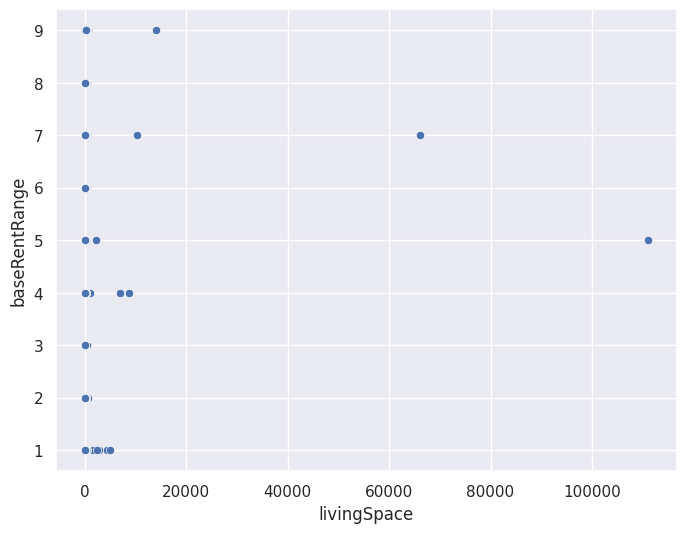

In [41]:
sns.scatterplot(data=apartment_df, x='livingSpace', y='baseRentRange')

In [42]:
(apartment_df['geo_plz'].value_counts() < 5).index

Int64Index([ 9130,  9126,  9131,  9112,  9113,  8056,  4157, 39112,  6217,  9599,
            ...
            98746, 99088, 99319, 99344, 99388, 99762, 99797, 99843, 99898, 99958], dtype='int64', length=7634)

[Text(0.5, 0, 'Number of listing'),
 Text(0, 0.5, 'City'),
 Text(0.5, 1.0, 'Nuber of listing of the top 10 German cities')]

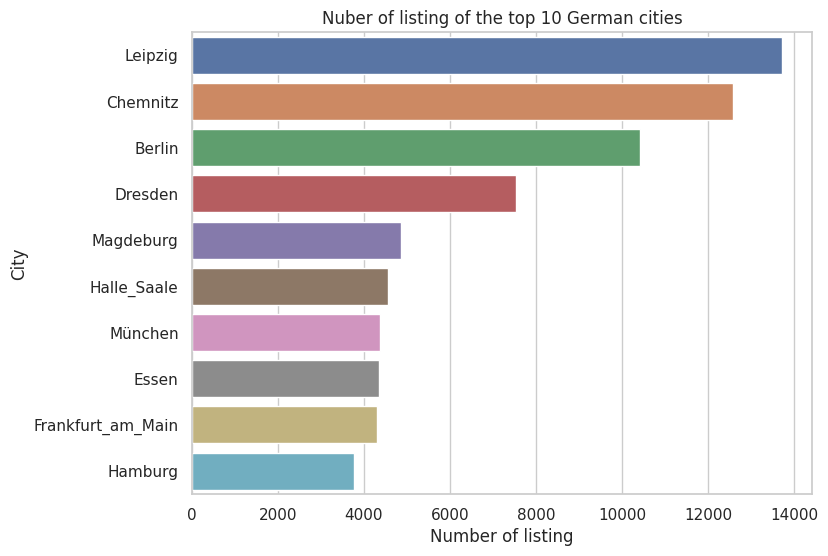

In [43]:
sns.set_style("whitegrid")
ax = sns.countplot(data= apartment_df, y = 'regio2', order=apartment_df.value_counts('regio2').iloc[:10].index,
              palette="deep")
ax.set(
    xlabel="Number of listing",
    ylabel="City",
    title="Nuber of listing of the top 10 German cities",
)

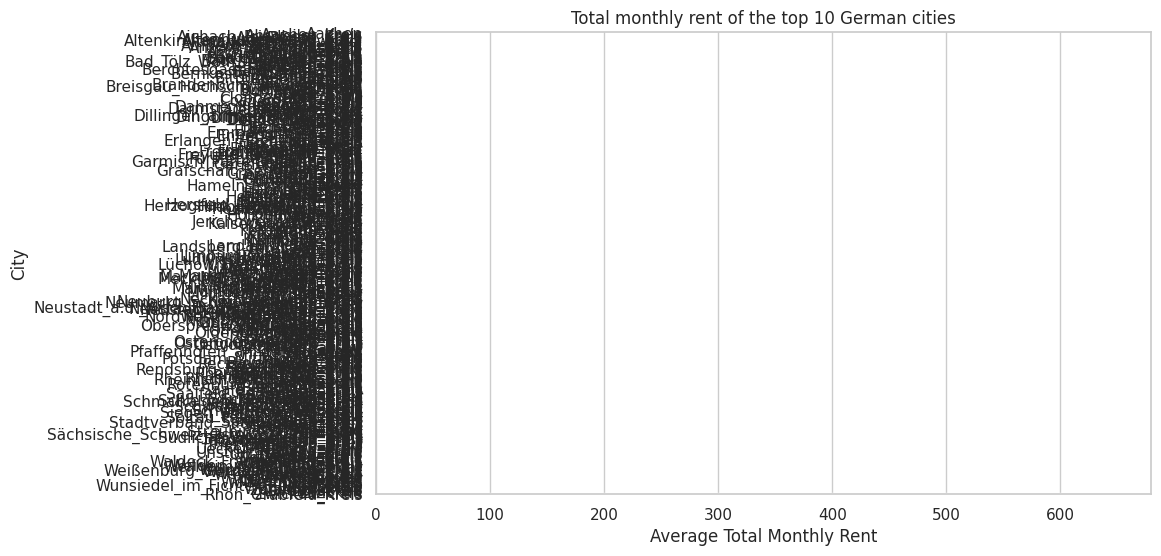

In [44]:
# Calculate mean and standard deviation for each city
mean_rent = apartment_df.groupby(by="regio2")["totalRent"].mean()
std_dev_rent = apartment_df.groupby(by="regio2")["totalRent"].std()
cities = mean_rent.index

# Sort the series by mean rent in descending order
mean_rent = mean_rent.sort_values(ascending=False)
std_dev_rent = std_dev_rent[mean_rent.index]  # Ensure index matches for both Series
cities = mean_rent.index

# Create a bar plot with error bars
plt.figure(figsize=(10,6))
sns.barplot(x=mean_rent, y=cities, palette="deep")
# plt.errorbar(mean_rent, np.arange(len(cities)), xerr=std_dev_rent, fmt='o', color='black', capsize=5)
plt.xlabel('Average Total Monthly Rent')
plt.ylabel('City')
plt.title('Total monthly rent of the top 10 German cities')
plt.show()

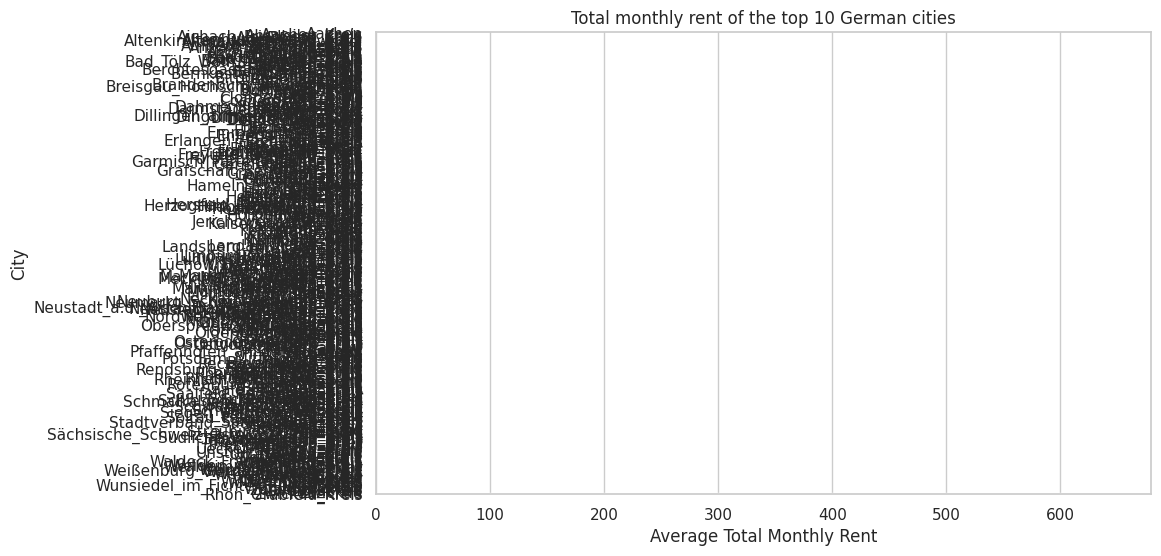

In [45]:
# Calculate mean and standard deviation for each city
mean_rent = apartment_df.groupby(by="regio2")["totalRent"].mean()
std_dev_rent = apartment_df.groupby(by="regio2")["totalRent"].std()
cities = mean_rent.index

# Sort the series by mean rent in descending order
mean_rent = mean_rent.sort_values(ascending=False)
std_dev_rent = std_dev_rent[mean_rent.index]  # Ensure index matches for both Series
cities = mean_rent.index

# Create a bar plot with error bars
plt.figure(figsize=(10,6))
sns.barplot(x=mean_rent, y=cities, palette="deep")
# plt.errorbar(np.arange(len(cities)), mean_rent, yerr=std_dev_rent, fmt='o', color='black', capsize=5)
plt.xlabel('Average Total Monthly Rent')
plt.ylabel('City')
plt.title('Total monthly rent of the top 10 German cities')
plt.show()

The target is predict the `totalRent` values. There are plenty of columns in the data that are less relevant with the task. Therefore, those will be dropped.
Of course, the first part does not consider: `facilities`,`description`
The table below shows the dropped columns that are not relevant:

|Table name | Description | Note |
| --------- | ----------- | ---- |
| facilities | textual data | for part 2 |
| description | textual data | for part 2 |
|telekomHybridUploadSpeed| 
|date | time of scraping | not relevant |
|scoutid | id in the website Immoscout24 | not relevant|
|picturecount | number of picture uploaded | in this case, not consider|
|pricetrend | price trend as calculated by Immoscout | not relevant|
|geo_bln | bundesland (state), same as regio1 | duplicated|
|geo_krs | District or Kreis, same as regio2 | duplicated |
|street | a diff. format of `streetPlain` | duplicated |
|houseNumber | house number| not relevant|

## Treatments of the target column
* The target of this research is to predict the total rent, therefore, all missing values of the column `totalRent` will be dropped

In [46]:
missing_percent = 100 * (apartment_df['totalRent'].isna().sum() / apartment_df['totalRent'].shape[0])
print(f'Percentage of missing data in total rent will be dropped: {round(missing_percent,3)} %')
apartment_df = apartment_df.dropna(subset=['totalRent'])

Percentage of missing data in total rent will be dropped: 15.07 %


* Detecting outliers

Detecting outliers by determining an interval spanning over the mean plus/minus three standard deviations (or z-score < $\pm 3$) remains a common practice. However, since both the mean and the standard deviation are particularly sensitive to outliers, this method is problematic. We highlight the disadvantages of this method and present the median absolute deviation, an alternative and more robust measure of dispersion that is easy to implement. We also explain the procedures for calculating this indicator in SPSS and R software.

In [47]:
x = apartment_df['totalRent']
m = apartment_df['totalRent'].mean()
s = apartment_df['totalRent'].std()
x_bar = x - m / s
apartment_df['LogtotalRent'] = cp.log(apartment_df['totalRent'] + 1)
x_bar = apartment_df['LogtotalRent']

In [48]:
iqr = x.quantile(0.75) - x.quantile(0.25)
high = x.median() + 2.22 * iqr
low = x.median() - 2.22 * iqr
print(f'high: {high}')
print(f'low: {low}')

high: 1793.7440000000001
low: -493.74400000000014


In [49]:
mad = compute_mad_1d(x_bar); mad

array(0.54542486)

In [50]:
upper = x_bar.median() + 4. * mad
print(f'upper: {upper} => {cp.exp(upper) -1}')
lower = x_bar.median() - 3 * mad
print(f'lower: {lower} => {cp.exp(lower) -1}')

upper: 8.66020908949238 => 5767.740719480238
lower: 4.842235056745711 => 125.7523340307722


In [51]:
x_bar[x_bar > upper].shape

(186,)

In [52]:
x_bar[x_bar < lower].shape

(333,)

(array([2.61000e+02, 1.80000e+01, 7.60000e+01, 1.37026e+05, 9.02260e+04,
        7.15000e+02, 6.00000e+00, 1.00000e+00, 3.00000e+00, 1.00000e+00]),
 array([ 0.        ,  1.65724484,  3.31448969,  4.97173453,  6.62897938,
         8.28622422,  9.94346907, 11.60071391, 13.25795875, 14.9152036 ,
        16.57244844]),
 <BarContainer object of 10 artists>)

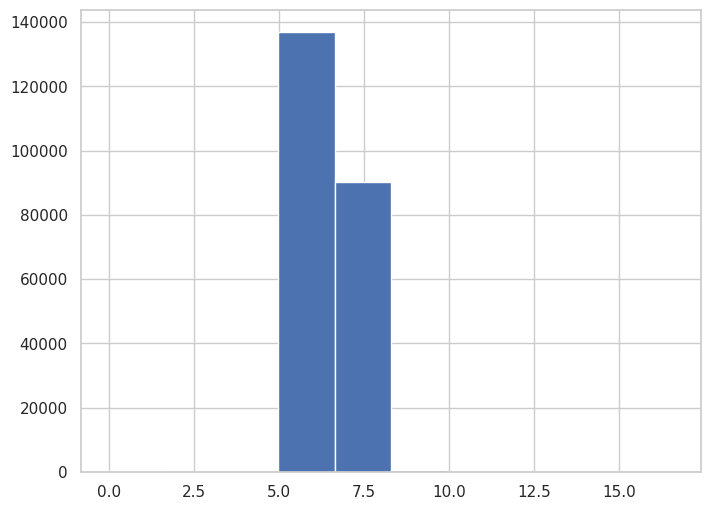

In [53]:
plt.hist(x_bar)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4de9f96fe0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4de9f97520>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4de9f96d40>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4de9f97a60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4de9f97d00>],
 'means': []}

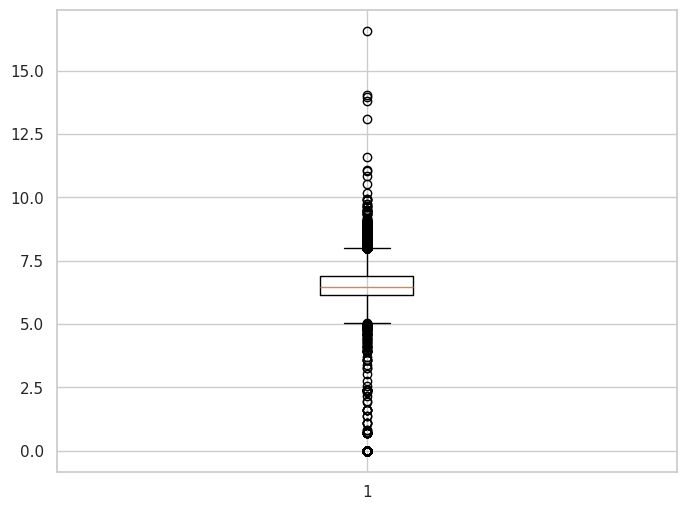

In [54]:
plt.boxplot(x_bar)

In [55]:
outliers = x_bar[(x_bar < lower) | (x_bar > upper)]
outliers.shape

(519,)

In [56]:
x_drop = x_bar.drop(outliers.index)

<Axes: ylabel='LogtotalRent'>

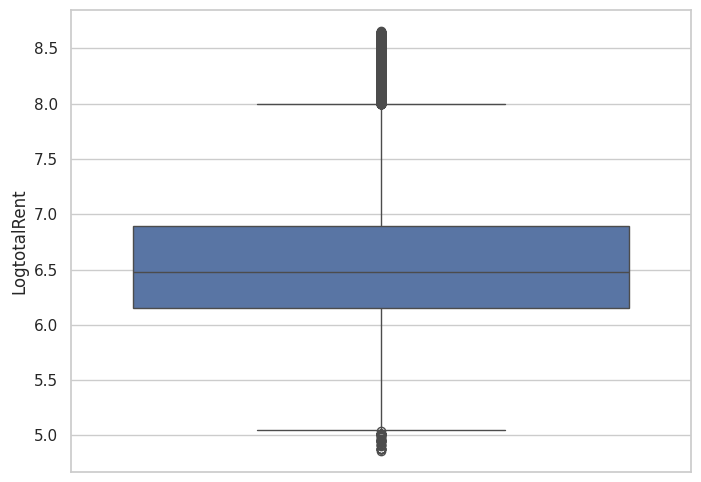

In [57]:
sns.boxplot(x_drop)

In [58]:
x_back = pd.Series(cp.exp(x_drop)- 1)

In [59]:
fig = plt.figure(10,8)
sns.histplot(x_drop.to_numpy())
sns.histplot(x_back.to_numpy())

TypeError: Value after * must be an iterable, not int

In [ ]:
x_back.max()

5750.000000000003

In [ ]:
import cupy as cp
cp.random.seed(1)
x = pd.DataFrame(cp.random.normal(0,1, (1000000,1)))
1/x.quantile(0.75)

0    1.481882
Name: 0.75, dtype: float64

In [ ]:
x.quantile(0.75)

0    0.674818
Name: 0.75, dtype: float64

In [ ]:
total_rent.quantile(0.75)

985.0

In [ ]:
apartment_df['serviceCharge'].isnull().sum() / apartment_df.shape[0]

0.0179124349086641

In [ ]:
check = apartment_df['totalRent'] - (apartment_df['baseRent'] + apartment_df['serviceCharge'])

In [ ]:
apartment_df['totalRent'].describe()

count    2.283330e+05
mean     9.013315e+02
std      3.323833e+04
min      0.000000e+00
25%      4.698000e+02
50%      6.500000e+02
75%      9.850000e+02
max      1.575154e+07
Name: totalRent, dtype: float64

In [ ]:
from scipy import stats
test = apartment_df['totalRent'].dropna(axis=0)
test2 = test[(np.abs(stats.zscore(test)) < 1.)]
print(f'Drop {test.shape[0] - test2.shape[0]} rows')

Drop 10 rows


In [ ]:
1 / stats.norm.ppf(0.75)

1.482602218505602

In [ ]:
test2.max()

26500.0

<Axes: >

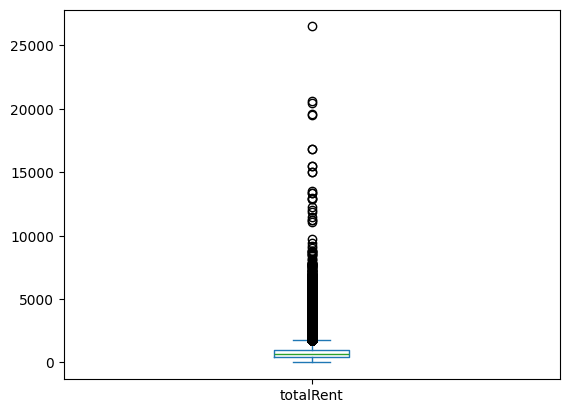

In [ ]:
test2.plot.box()
# apartment_df['baseRent'].plot.box()

<Axes: ylabel='Density'>

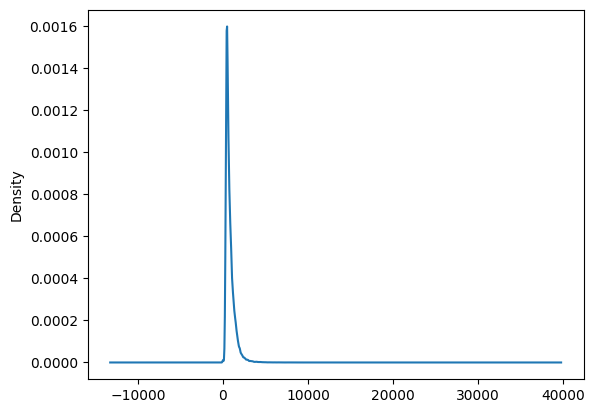

In [ ]:
# apartment_df['totalRent'].plot.kde()
test2.plot.kde()

40517

Drop all the missing values of the main target column `totalRent`

In [ ]:
clean_df['totalRent'].isnull().sum()

40517

In [ ]:
clean_df['baseRentRange'].isna().sum()

40517

In [ ]:
# drop the data where the columns contains more than 30%
49 - len(clean_df.columns)

21

In [ ]:
sns.heatmap(clean_df.corr())

ValueError: could not convert string to float: 'Nordrhein_Westfalen'

In [ ]:
def get_percentage_of_values(df):
    """
    Returns a dictionary where keys are the names of boolean columns in a pandas DataFrame 
    and values are dictionaries with percentage distribution of True/False values.
  
    Args:
        df (pandas.DataFrame): A pandas DataFrame to be analyzed.
      
    Returns:
        dict: Column names as keys, corresponding dictionary of percentages of values as values.
     """
  
    if not isinstance(df, pd.DataFrame):
        raise TypeError('Input must be a pandas DataFrame')
        
    if df.shape[1] == 0:
        raise ValueError('Input DataFrame has no columns')

    # Filter for boolean columns
    filtered_columns = df.select_dtypes(include=['bool']).columns
  
    distributions = {}  # Initialize an empty dictionary to hold the results
    
    for column in filtered_columns:
        value_counts = df[column].value_counts()  # Get count of True/False values in this column
        total = df.shape[0]  # Total number of rows in DataFrame
        
        distribution = {}   # Initialize an empty dictionary to hold the percentages for this column
        for value, count in value_counts.items():
            percentage = (count / total) * 100    # Calculate the percentage
            distribution[value] = round(percentage, 2)  # Add to distribution dictionary with rounded percentage
        
        distributions[column] = distribution  # Add distribution to results dictionary
    
    return distributions